## Polyfit emulator covariance

I noticed a bug in the calculation of the polyfit emulator uncertainty. At https://github.com/igmhub/LaCE/blob/main/lace/emulator/gp_emulator.py#L351 we have `err=(err[0]*interpolated_P**4+err[1]*interpolated_P**3+err[2]*interpolated_P**2+err[3]*interpolated_P)` which is incorrect. So I'll start by rederiving a more well motivated formula, and test the impact on the end covariances.

For some function $Q(x,y,z)$, if we have uncertainties $\sigma_x$, $\sigma_y$, $\sigma_z$, we can express the uncertainty on $Q$ as:

$$\sigma_Q^2=\sigma_x^2\bigg(\frac{\partial Q}{\partial x}\bigg)^2 + \sigma_y^2\bigg(\frac{\partial Q}{\partial y}\bigg)^2 + \sigma_z^2\bigg(\frac{\partial Q}{\partial z}\bigg)^2$$

Our polyfit emulator models the $P_\mathrm{1D}$ as a polynomial in logspace:

$$P_\mathrm{1D}=\exp[c_0+c_1(\log k_\parallel)+c_2(\log k_\parallel)^2+c_3(\log k_\parallel)^3+(\log k_\parallel)^4]$$

and returns variances on each of these coefficients, $c_n$, i.e. $\sigma_{cn}$. We want to propagate this to an uncertainty on the $P_\mathrm{1D}$. If we define

$$g=c_0+c_1(\log k_\parallel)+c_2(\log k_\parallel)^2+c_3(\log k_\parallel)^3+(\log k_\parallel)^4,$$
$$P_\mathrm{1D}=\exp(g)$$

using the chain rule:

$$\frac{\partial P_\mathrm{1D}}{\partial c_n}=\exp(g)\frac{\partial g}{\partial c_n}=P_\mathrm{1D}\frac{\partial g}{\partial c_n}.$$

Combining the above, we obtain

$$\sigma_{P1D}^2=P_\mathrm{1D}^2\big(\sigma_{c0}^2+\sigma_{c1}^2(\log k_\parallel)+\sigma_{c2}^2(\log k_\parallel)^2+\sigma_{c3}^2(\log k_\parallel)^3+\sigma_{c4}^2(\log k_\parallel)^4\big)$$

Implemented in the code, this looks like: 

```err2=(interpolated_P**2)*(err[0]*np.log(k_Mpc)**4+err[1]*np.log(k_Mpc)**3+err[2]*np.log(k_Mpc)**2+err[3]*np.log(k_Mpc)+err[4])```

```err=np.sqrt(err2)```

However, the problem with doing this now is that the emulator covariance is way too large! As a test below, I look at predictions for the central sim, and a randomly chosen simulation that's inside the training set. A well-behaved covariance will be non-negligible for the central sim, and essentially zero for the sim in the training set. We do not get this behaviour with the above implementation. When printing out the coefficients, they do change (between two orders of magnitude for the higher order coefficients, and roughly a factor of 3 for the constant), but this doesn't really translate into much difference on the uncertainty on the emulated p1d.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Lace modules
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace.cosmo import camb_cosmo
from lace.cosmo import fit_linP
from lace_manager.emulator import test_simulation

In [2]:
## Load training set
skewers_label='Ns500_wM0.05'
p1d_label=None
kmax_mpc=8
basedir="/lace/emulator/sim_suites/Australia20/"
archive=p1d_archive.archiveP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,nearest_tau=False,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [3]:
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                verbose=False,paramList=None,train=True,
                                kmax_Mpc=8,
                                #rbf_only=True,asymmetric_kernel=True,
                                emu_type="polyfit",passarchive=archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /home/chrisp/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 270 points
Optimised


In [4]:
Test_central=test_simulation.TestSimulation(basedir,"central",skewers_label)
Test_training=test_simulation.TestSimulation(basedir,5,skewers_label)

In [6]:
idx=np.where(Test_central.k_Mpc<kmax_mpc)
k_mpc=Test_central.k_Mpc[idx[0][1:]]

In [ ]:
k_mpc.shape

Coefficients: [-0.03308    -0.13625247 -0.3054785  -0.7658024  -2.47752366]
Coefficient error: [0.0001227  0.00050567 0.0011531  0.00328436 0.00690251]
Coefficients: [-0.03123122 -0.13030102 -0.29268544 -0.74169374 -2.20254098]
Coefficient error: [0.00011886 0.00048983 0.00111698 0.00318147 0.00668627]
Coefficients: [-0.02923391 -0.12335911 -0.2785388  -0.71818598 -1.9289511 ]
Coefficient error: [0.00012537 0.00051666 0.00117816 0.00335574 0.00705251]
Coefficients: [-0.02739925 -0.11599472 -0.26315167 -0.69644448 -1.66190554]
Coefficient error: [0.00013384 0.00055155 0.00125773 0.00358237 0.0075288 ]
Coefficients: [-0.02594195 -0.10883417 -0.24680095 -0.6769518  -1.40914169]
Coefficient error: [0.00014034 0.00057836 0.00131887 0.00375651 0.00789479]
Coefficients: [-0.02483237 -0.1019378  -0.22942244 -0.65952896 -1.16565327]
Coefficient error: [0.00014429 0.00059463 0.00135596 0.00386216 0.00811683]
Coefficients: [-0.02389441 -0.09568761 -0.21287499 -0.64361167 -0.93052271]
Coefficient 

Text(0.5, 0, '$k_\\parallel$ [1/Mpc]')

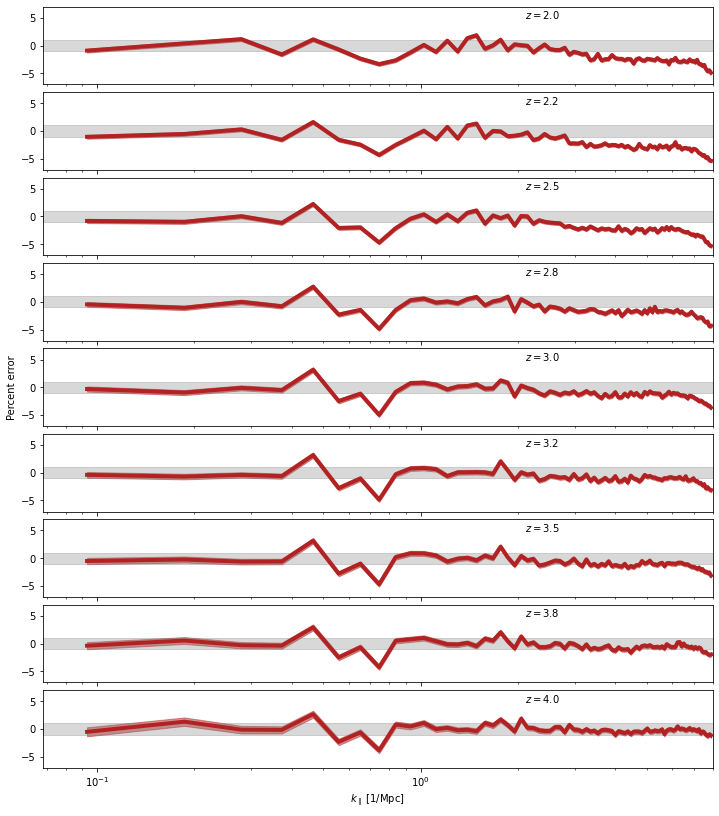

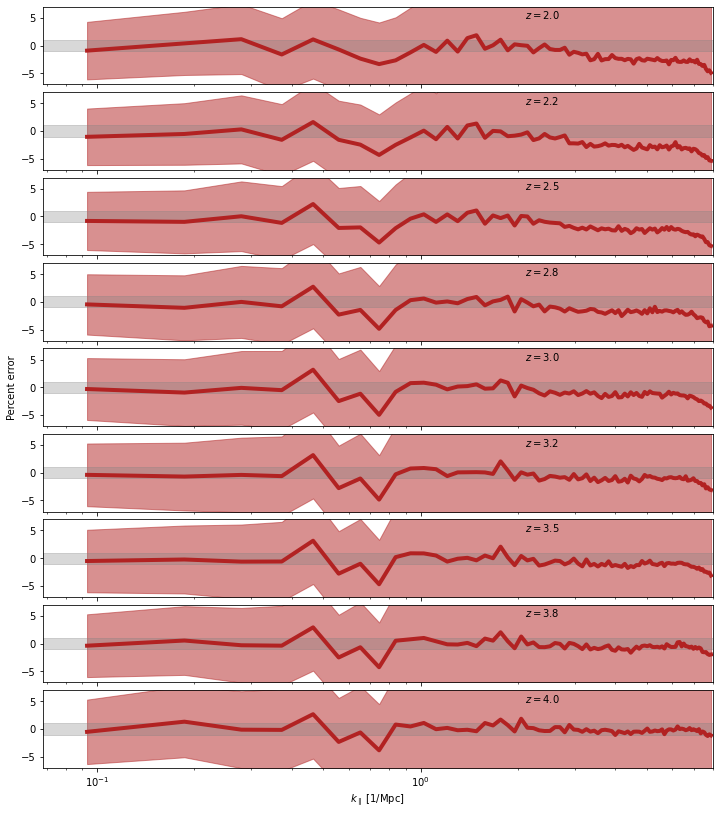

In [14]:
xmin=0.068
xmax=8


plt.figure(figsize=[12,14])
dex=0
for aa in range(0,9,1):
    plt.subplot(9,1,(aa+1))
    col = "firebrick"
    
    test_k_mpc,test_pk_mpc=Test_central.get_p1d_Mpc(Test_central.zs[aa])
    pk_test=test_pk_mpc[idx[0][1:]]
    pred,err=emu.emulate_p1d_Mpc(Test_central.get_emulator_calls(Test_central.zs[aa]),k_mpc,True,Test_central.zs[aa])
    
    
    plt.plot(k_mpc,100*((pred/pk_test)-1),color=col,linewidth=4)
    #plt.plot(k_test,100*(mean_error_rbf[aa,:]),color="black")
    #plt.plot(k_test,-100*mean_error_rbf[aa,:],color="black")
    plt.fill_between(k_mpc,100*((pred+np.sqrt(np.diag(err)))/pk_test-1),
            100*((pred-np.sqrt(np.diag(err)))/pk_test-1),alpha=0.5,color=col)
    plt.axhspan(-1,1,color="gray",alpha=0.3)

    #plt.axhline(0,linestyle="dashed",color="gray")
    plt.ylim(-7,7)
    #plt.legend(loc="lower right")
    ax = plt.gca()
    ax.set_xscale("log")
    plt.xlim(xmin,xmax)
    #ax.tick_params(top=True,right=True)
    
    ax.text(2.1,4.8,r"$z=%.1f$" % Test_central.zs[aa])

    if aa != 8:
        ax.axes.xaxis.set_ticklabels([])
        #ax.axes.yaxis.set_ticklabels([])
    if aa==4:
        plt.ylabel("Percent error")
plt.subplots_adjust(hspace=0.1)
plt.xlabel(r"$k_\parallel$ [1/Mpc]")


plt.figure(figsize=[12,14])
dex=0
for aa in range(0,9,1):
    plt.subplot(9,1,(aa+1))
    col = "firebrick"
    
    test_k_mpc,test_pk_mpc=Test_central.get_p1d_Mpc(Test_central.zs[aa])
    pk_test=test_pk_mpc[idx[0][1:]]
    pred,err=emu.emulate_p1d_Mpc(Test_central.get_emulator_calls(Test_central.zs[aa]),k_mpc,True,Test_central.zs[aa],old_cov=False)
    
    
    plt.plot(k_mpc,100*((pred/pk_test)-1),color=col,linewidth=4)
    #plt.plot(k_test,100*(mean_error_rbf[aa,:]),color="black")
    #plt.plot(k_test,-100*mean_error_rbf[aa,:],color="black")
    plt.fill_between(k_mpc,100*((pred+np.sqrt(np.diag(err)))/pk_test-1),
            100*((pred-np.sqrt(np.diag(err)))/pk_test-1),alpha=0.5,color=col)
    plt.axhspan(-1,1,color="gray",alpha=0.3)

    #plt.axhline(0,linestyle="dashed",color="gray")
    plt.ylim(-7,7)
    #plt.legend(loc="lower right")
    ax = plt.gca()
    ax.set_xscale("log")
    plt.xlim(xmin,xmax)
    #ax.tick_params(top=True,right=True)
    
    ax.text(2.1,4.8,r"$z=%.1f$" % Test_central.zs[aa])

    if aa != 8:
        ax.axes.xaxis.set_ticklabels([])
        #ax.axes.yaxis.set_ticklabels([])
    if aa==4:
        plt.ylabel("Percent error")
plt.subplots_adjust(hspace=0.1)
plt.xlabel(r"$k_\parallel$ [1/Mpc]")

Coefficients: [-0.0333329  -0.16010282 -0.37219993 -0.779166   -2.54725057]
Coefficient error: [5.84206579e-05 2.40755952e-04 5.49011080e-04 1.56373748e-03
 3.28639486e-03]
Coefficients: [-0.03161555 -0.15426008 -0.35598063 -0.74504674 -2.25742422]
Coefficient error: [5.27481705e-05 2.17379202e-04 4.95703593e-04 1.41190281e-03
 2.96729484e-03]
Coefficients: [-0.02951239 -0.14658351 -0.33925965 -0.71635728 -1.96878732]
Coefficient error: [5.13307078e-05 2.11537731e-04 4.82382916e-04 1.37396179e-03
 2.88755691e-03]
Coefficients: [-0.02743263 -0.13771013 -0.32111453 -0.69295245 -1.68388259]
Coefficient error: [5.11936355e-05 2.10972846e-04 4.81094773e-04 1.37029280e-03
 2.87984605e-03]
Coefficients: [-0.02579733 -0.12843956 -0.30037769 -0.67301952 -1.40959496]
Coefficient error: [5.12841436e-05 2.11345836e-04 4.81945327e-04 1.37271541e-03
 2.88493749e-03]
Coefficients: [-0.02463296 -0.11908035 -0.27705497 -0.65488168 -1.14292327]
Coefficient error: [5.24002756e-05 2.15945501e-04 4.9243423

Text(0.5, 0, '$k_\\parallel$ [1/Mpc]')

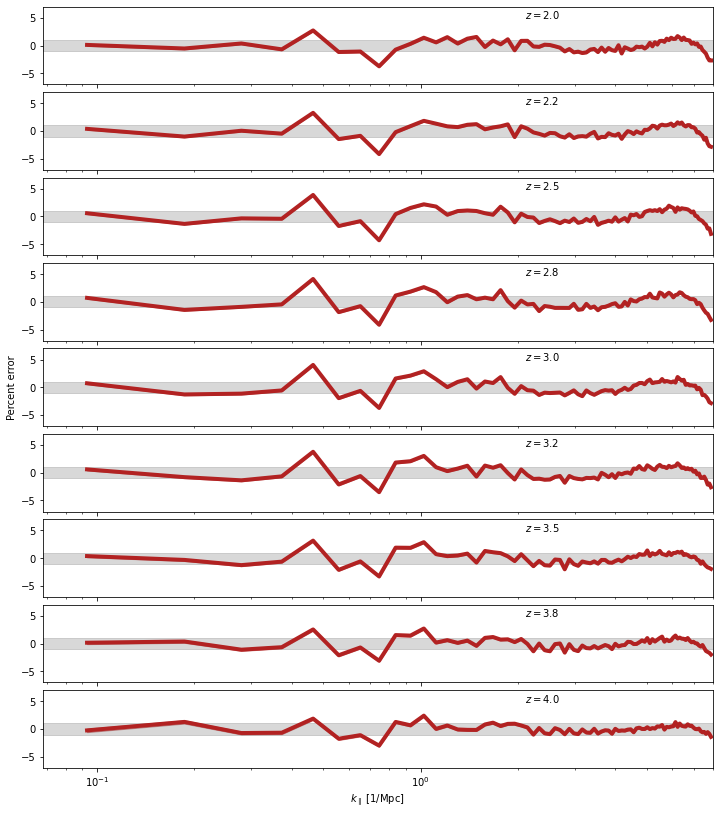

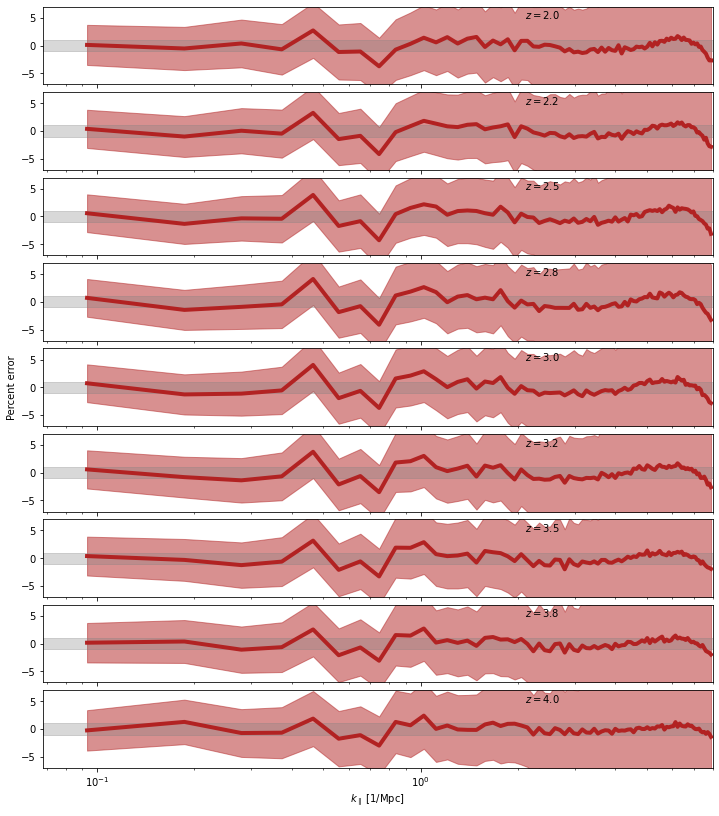

In [15]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,9,1):
    plt.subplot(9,1,(aa+1))
    col = "firebrick"
    
    test_k_mpc,test_pk_mpc=Test_training.get_p1d_Mpc(Test_training.zs[aa])
    pk_test=test_pk_mpc[idx[0][1:]]
    pred,err=emu.emulate_p1d_Mpc(Test_training.get_emulator_calls(Test_training.zs[aa]),k_mpc,True,Test_training.zs[aa])
    
    
    plt.plot(k_mpc,100*((pred/pk_test)-1),color=col,linewidth=4)
    #plt.plot(k_test,100*(mean_error_rbf[aa,:]),color="black")
    #plt.plot(k_test,-100*mean_error_rbf[aa,:],color="black")
    plt.fill_between(k_mpc,100*((pred+np.sqrt(np.diag(err)))/pk_test-1),
            100*((pred-np.sqrt(np.diag(err)))/pk_test-1),alpha=0.5,color=col)
    plt.axhspan(-1,1,color="gray",alpha=0.3)

    #plt.axhline(0,linestyle="dashed",color="gray")
    plt.ylim(-7,7)
    #plt.legend(loc="lower right")
    ax = plt.gca()
    ax.set_xscale("log")
    plt.xlim(xmin,xmax)
    #ax.tick_params(top=True,right=True)
    
    ax.text(2.1,4.8,r"$z=%.1f$" % Test_training.zs[aa])

    if aa != 8:
        ax.axes.xaxis.set_ticklabels([])
        #ax.axes.yaxis.set_ticklabels([])
    if aa==4:
        plt.ylabel("Percent error")
plt.subplots_adjust(hspace=0.1)
plt.xlabel(r"$k_\parallel$ [1/Mpc]")


plt.figure(figsize=[12,14])
dex=0
for aa in range(0,9,1):
    plt.subplot(9,1,(aa+1))
    col = "firebrick"
    
    test_k_mpc,test_pk_mpc=Test_training.get_p1d_Mpc(Test_training.zs[aa])
    pk_test=test_pk_mpc[idx[0][1:]]
    pred,err=emu.emulate_p1d_Mpc(Test_training.get_emulator_calls(Test_training.zs[aa]),k_mpc,True,Test_training.zs[aa],old_cov=False)
    
    
    plt.plot(k_mpc,100*((pred/pk_test)-1),color=col,linewidth=4)
    #plt.plot(k_test,100*(mean_error_rbf[aa,:]),color="black")
    #plt.plot(k_test,-100*mean_error_rbf[aa,:],color="black")
    plt.fill_between(k_mpc,100*((pred+np.sqrt(np.diag(err)))/pk_test-1),
            100*((pred-np.sqrt(np.diag(err)))/pk_test-1),alpha=0.5,color=col)
    plt.axhspan(-1,1,color="gray",alpha=0.3)

    #plt.axhline(0,linestyle="dashed",color="gray")
    plt.ylim(-7,7)
    #plt.legend(loc="lower right")
    ax = plt.gca()
    ax.set_xscale("log")
    plt.xlim(xmin,xmax)
    #ax.tick_params(top=True,right=True)
    
    ax.text(2.1,4.8,r"$z=%.1f$" % Test_training.zs[aa])

    if aa != 8:
        ax.axes.xaxis.set_ticklabels([])
        #ax.axes.yaxis.set_ticklabels([])
    if aa==4:
        plt.ylabel("Percent error")
plt.subplots_adjust(hspace=0.1)
plt.xlabel(r"$k_\parallel$ [1/Mpc]")